# Colab and Drive Setup

In [32]:
# mount to my Google Drive
from google.colab import drive
# drive.mount('/content/drive')
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [33]:
%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [35]:
!ls /content/gdrive/MyDrive/mimic_synthetic_data/Data/mimiciv/hosp_v3

admissions.csv.gz	       patients.csv.gz
diagnoses_icd.csv.gz	       prescriptions.csv.gz
diagnoses_selected_cohort.csv  prescriptions_selected_cohort.csv
hcpcsevents.csv.gz	       procedures_icd.csv.gz
omr.csv.gz		       procedures_icd_selected_cohort.csv


In [36]:
%cd /content
!git clone https://github.com/sfurlow8/tutorial_data_synthesis_and_evaluation.git
%cd tutorial_data_synthesis_and_evaluation
!ls

/content
fatal: destination path 'tutorial_data_synthesis_and_evaluation' already exists and is not an empty directory.
/content/tutorial_data_synthesis_and_evaluation
att_risk_tutorial.py				 rank_datasets.ipynb
Data						 README.md
data_checks					 requirements_colab.txt
data_extraction_and_preprocessing_process.ipynb  requirements_v2.txt
GAN_generation.py				 requirement.txt
GAN_training_notebook.ipynb			 run_training.ipynb
GAN_training.py					 training
mem_risk_tutorial.py				 utility_evaluation.ipynb
privacy_evaluation.ipynb			 utils


In [38]:
!ls /content/gdrive/MyDrive/mimic_synthetic_data/Data/mimiciv/hosp_v3

admissions.csv.gz	       patients.csv.gz
diagnoses_icd.csv.gz	       prescriptions.csv.gz
diagnoses_selected_cohort.csv  prescriptions_selected_cohort.csv
hcpcsevents.csv.gz	       procedures_icd.csv.gz
omr.csv.gz		       procedures_icd_selected_cohort.csv


In [39]:
!ls /content/gdrive/MyDrive/mimic_synthetic_data/Data/preprocessing/test

one_y_outcome.npy
patient_diagnosis_dict.npy
patient_procedures_hcpcs_dict.npy
patient_procedures_icd_dict.npy
patients_anchor_age_not_last_v_y.npy
patients_dict_w_admission_n_die_inhosp.npy
patients_dict_w_admission.npy
patients_w_icd_diag_9_10.npy
patients_w_icd_proc_9_10.npy


In [40]:
!nvidia-smi

Sun Feb 22 03:10:33 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [5]:
import torch
print(torch.cuda.is_available()) # should be true
print(torch.cuda.get_device_name(0)) # should be NVIDIA A100-SXM4-40GB

True
NVIDIA A100-SXM4-40GB


In [2]:
!pip install -r requirements_colab.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements_colab.txt'


# Run Preprocessing

In [3]:
import numpy as np
import pandas as pd
import requests
from datetime import datetime
from collections import OrderedDict
import copy
import matplotlib.pyplot as plt
import random
import os
import gc

In [41]:
current_directory = os.getcwd()
print(current_directory)

/content/tutorial_data_synthesis_and_evaluation


# load raw data: MIMIC-IV v2.0

## 1. Cohort extraction: patients with admission history and didn't die in hospital. 

In [43]:
folder_name = '/content/gdrive/MyDrive/mimic_synthetic_data/Data/mimiciv/hosp_v3' ## replace with your local path for mimiciv-2.0 data
save_folder_name = '/content/gdrive/MyDrive/mimic_synthetic_data/Data/preprocessing/test' ## replace with your local path for saving files during preprocessing
if not os.path.exists(save_folder_name):
    os.makedirs(save_folder_name)

In [46]:
# load patients, make patient dictionary.
patients = pd.read_csv(folder_name + '/patients.csv.gz')
patients_dict = {}
for row in patients.values:
    patients_dict[row[0]] = [row[1], row[2], row[3], row[4], row[5]]  # gender, anchor_age, anchor_year, anchor_year_group, dod

# load admission
admissions = pd.read_csv(folder_name + '/admissions.csv.gz')
patients_anchor_age_not_last_v_y = {}
tmp = admissions.groupby(['subject_id'])
for key, item in tmp:
    # FIXED: Convert tuple key to integer (pandas groupby returns tuple for single column list)
    key = key[0] if isinstance(key, tuple) else key
    # Convert tuple key to integer if needed
    key = key[0] if isinstance(key, tuple) else key
    group_df = tmp.get_group(key)
    group_df = group_df.reset_index(drop=True)
    discharge_time_list = [datetime.strptime(str_time, "%Y-%m-%d %H:%M:%S") for str_time in list(group_df['dischtime'])]
    last_discharge_timestr = sorted(discharge_time_list, key=lambda t: t, reverse=True)[0].strftime("%Y-%m-%d %H:%M:%S")
    last_admission_row_id = list(group_df['dischtime'] == last_discharge_timestr).index(1)
    if key in patients_dict.keys():
        patients_dict[key] = patients_dict[key] + [group_df.iloc[last_admission_row_id]['race'], group_df.iloc[last_admission_row_id]['hadm_id'], group_df.iloc[last_admission_row_id]['admittime'], group_df.iloc[last_admission_row_id]['dischtime'], group_df.iloc[last_admission_row_id]['deathtime'], group_df.iloc[last_admission_row_id]['admission_type'], group_df.iloc[last_admission_row_id]['insurance'], group_df.iloc[last_admission_row_id]['admission_location'], group_df.iloc[last_admission_row_id]['discharge_location']]
    
    if patients_dict[key][2] != int(patients_dict[key][7][:4]):
        patients_anchor_age_not_last_v_y[key] = [patients_dict[key][1], patients_dict[key][2], patients_dict[key][7]]

patients_dict_w_admission = {}
patients_dict_w_admission_n_die_inhosp = {}
one_y_outcome = {}
die_count = 0
for key, ele in patients_dict.items():
    if len(ele) > 5:
        patients_dict_w_admission[key] = ele
        if ele[9] != ele[9]: # patients not die in hospital
            patients_dict_w_admission_n_die_inhosp[key] = ele
            if ele[4] == ele[4]:
                one_y_outcome[key] = 1  # die in one year after last hospital stay
                die_count += 1
            else:
                one_y_outcome[key] = 0  # not die in one year after last hospital stay

print("Num of patients in total: %d" % len(patients_dict))        
print("Num of patients with admissions: %d" % len(patients_dict_w_admission))
print("Num of patients with admissions and not die in hospital: %d" % len(patients_dict_w_admission_n_die_inhosp))
print("    among which, %d (%.2f) patients died in one year after their last admission." % (die_count, die_count/len(patients_dict_w_admission_n_die_inhosp))) 


np.save(save_folder_name + '/patients_dict_w_admission.npy', patients_dict_w_admission)
np.save(save_folder_name + '/patients_anchor_age_not_last_v_y.npy', patients_anchor_age_not_last_v_y)
np.save(save_folder_name + '/patients_dict_w_admission_n_die_inhosp.npy', patients_dict_w_admission_n_die_inhosp)
np.save(save_folder_name + '/one_y_outcome.npy', one_y_outcome)


/tmp/ipython-input-1975723797.py:16: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group_df = tmp.get_group(key)


Num of patients in total: 315460
Num of patients with admissions: 190279
Num of patients with admissions and not die in hospital: 181294
    among which, 20493 (0.11) patients died in one year after their last admission.


## 2. Diagnosis extraction

In [29]:
# load diagnoses. note that this could take ~3h to run.
diagnoses = pd.read_csv(folder_name + '/diagnoses_icd.csv.gz')
diagnoses_pt_df = pd.DataFrame()
tmp = diagnoses.groupby(['subject_id'])

for key, item in tmp:
    # FIXED: Convert tuple key to integer 
    key = key[0] if isinstance(key, tuple) else key
    if key in patients_dict_w_admission_n_die_inhosp.keys():
        group_df = tmp.get_group(key)
        group_df = group_df.reset_index(drop=True)
        diagnoses_pt_df = pd.concat([diagnoses_pt_df, group_df], ignore_index=True)
        
diagnoses_pt_df.to_csv(folder_name + '/diagnoses_selected_cohort.csv', index=False)

# diagnoses_pt_df = pd.read_csv(folder_name + '/diagnoses_selected_cohort.csv')


/tmp/ipython-input-3677340384.py:10: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group_df = tmp.get_group(key)


In [31]:
patient_diagnosis_dict = {}
patients_w_icd_9_10 = []
temp = diagnoses_pt_df.groupby(['subject_id', 'icd_version'])
# FIXED: Convert tuple key to integer 
for key, item in temp:
    # key = key[0] if isinstance(key, tuple) else key
    if key[0] not in patient_diagnosis_dict.keys():
        patient_diagnosis_dict[key[0]] = {'icd9':[], 'icd10':[]}
    if key[1] == 9:
        patient_diagnosis_dict[key[0]]['icd9'] = list(set(item['icd_code']))
    else:
        patient_diagnosis_dict[key[0]]['icd10'] = list(set(item['icd_code']))
    
    if len(patient_diagnosis_dict[key[0]]['icd9']) > 0 and len(patient_diagnosis_dict[key[0]]['icd10']) > 0:
        patients_w_icd_9_10.append(key[0])

np.save(save_folder_name + '/patient_diagnosis_dict.npy', patient_diagnosis_dict)
np.save(save_folder_name + '/patients_w_icd_diag_9_10.npy', patients_w_icd_9_10)

## 3. Procedure extraction

In [34]:
# load procedure hcpcs
procedures_hcpcs = pd.read_csv(folder_name + '/hcpcsevents.csv.gz')
procedures_hcpcs_pt_df = pd.DataFrame()
tmp = procedures_hcpcs.groupby(['subject_id'])
for key, item in tmp:
    # FIXED: Convert tuple key to integer (pandas groupby returns tuple for single column list)
    key = key[0] if isinstance(key, tuple) else key
    if key in patients_dict_w_admission_n_die_inhosp.keys():
        group_df = tmp.get_group(key)
        group_df = group_df.reset_index(drop=True)
        procedures_hcpcs_pt_df = pd.concat([procedures_hcpcs_pt_df, group_df], ignore_index=True)
        
# procedures_hcpcs_pt_df.to_csv(folder_name + '/procedures_hcpcs_selected_cohort.csv', index=False)

patient_procedures_hcpcs_dict = {}
temp = procedures_hcpcs_pt_df.groupby(['subject_id'])
for key, item in temp:
    # FIXED: Convert tuple key to integer (pandas groupby returns tuple for single column list)
    key = key[0] if isinstance(key, tuple) else key
    hcpcs_list = list(item['hcpcs_cd'])
    cpt_list = []
    for code in hcpcs_list:
        if not any(c.isalpha() for c in code):
            cpt_list.append(code)
    patient_procedures_hcpcs_dict[key] = list(set(cpt_list))
    
np.save(save_folder_name + '/patient_procedures_hcpcs_dict.npy', patient_procedures_hcpcs_dict)

/tmp/ipython-input-2898027431.py:9: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group_df = tmp.get_group(key)


In [36]:
# load procedure icd
procedures_icd = pd.read_csv(folder_name + '/procedures_icd.csv.gz')
procedures_icd_pt_df = pd.DataFrame()
tmp = procedures_icd.groupby(['subject_id'])
for key, item in tmp:
    # FIXED: Convert tuple key to integer (pandas groupby returns tuple for single column list)
    key = key[0] if isinstance(key, tuple) else key
    if key in patients_dict_w_admission_n_die_inhosp.keys():
        group_df = tmp.get_group(key)
        group_df = group_df.reset_index(drop=True)
        procedures_icd_pt_df = pd.concat([procedures_icd_pt_df, group_df], ignore_index=True)
        
procedures_icd_pt_df.to_csv(folder_name + '/procedures_icd_selected_cohort.csv', index=False)

/tmp/ipython-input-3057611180.py:9: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group_df = tmp.get_group(key)


In [38]:
patient_procedures_icd_dict = {}
patients_w_icd_9_10 = []
temp = procedures_icd_pt_df.groupby(['subject_id', 'icd_version'])
for key, item in temp:
    # FIXED: Convert tuple key to integer (pandas groupby returns tuple for single column list)
    # key = key[0] if isinstance(key, tuple) else key
    if key[0] not in patient_procedures_icd_dict.keys():
        patient_procedures_icd_dict[key[0]] = {'icd9':[], 'icd10':[]}
    if key[1] == 9:
        patient_procedures_icd_dict[key[0]]['icd9'] = list(set(item['icd_code']))
    else:
        patient_procedures_icd_dict[key[0]]['icd10'] = list(set(item['icd_code']))
    
    if len(patient_procedures_icd_dict[key[0]]['icd9']) > 0 and len(patient_procedures_icd_dict[key[0]]['icd10']) > 0:
        patients_w_icd_9_10.append(key[0])

np.save(save_folder_name + '/patient_procedures_icd_dict.npy', patient_procedures_icd_dict)
np.save(save_folder_name + '/patients_w_icd_proc_9_10.npy', patients_w_icd_9_10)


## 4. Prescription extraction

In [73]:
# load prescription (ndc codes)
prescriptions = pd.read_csv(folder_name + '/prescriptions.csv.gz', dtype={"ndc":str}) # np.str
prescriptions = prescriptions[["subject_id", "hadm_id", "ndc"]]
prescriptions_pt_df = pd.DataFrame()
tmp = prescriptions.groupby(['subject_id'])

/tmp/ipython-input-2623716722.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  prescriptions = pd.read_csv(folder_name + '/prescriptions.csv.gz', dtype={"ndc":str}) # np.str


In [74]:
prescriptions.head(5) # look at presc

,subject_id,hadm_id,ndc
0,10000032,22595853,00904198861
1,10000032,22595853,0
2,10000032,22595853,51079007320
3,10000032,22595853,00006022761
4,10000032,22595853,63323026201


In [78]:
# Convert once to set for fast membership testing
cohort_ids = set(patients_dict_w_admission_n_die_inhosp)

# Vectorized filter (VERY fast)
prescriptions_pt_df = prescriptions[
    prescriptions["subject_id"].isin(cohort_ids)
].copy()

prescriptions_pt_df.to_csv(
    f"{folder_name}/prescriptions_selected_cohort.csv",
    index=False
)

patient_prescriptions_dict = {}
temp = prescriptions_pt_df.groupby("subject_id")

In [79]:
# count = 0
# for key, item in tmp:
#     # FIXED: Convert tuple key to integer (pandas groupby returns tuple for single column list)
#     key = key[0] if isinstance(key, tuple) else key
#     if key in patients_dict_w_admission_n_die_inhosp.keys():
#         group_df = tmp.get_group(key)
#         group_df = group_df.reset_index(drop=True)
#         prescriptions_pt_df = pd.concat([prescriptions_pt_df, group_df], ignore_index=True)
        
#     count += 1
#     if count % 5000 == 1:
#         print(count)
        
# prescriptions_pt_df.to_csv(folder_name + '/prescriptions_selected_cohort.csv', index=False)

# patient_prescriptions_dict = {}
# temp = prescriptions_pt_df.groupby(['subject_id'])

In [80]:
for key, item in temp: # tmp
    candidate_list = list(set(item['ndc']))
    if '0' in candidate_list:
        candidate_list.remove('0')
    patient_prescriptions_dict[key] = candidate_list

np.save(save_folder_name + '/patient_prescriptions_dict.npy', patient_prescriptions_dict)

## 5. Other measure extraction

In [56]:
# load BMI blood pressure (diastolic/systolic)
measures = pd.read_csv(folder_name + '/omr.csv.gz')
measures_pt_df = pd.DataFrame()
tmp = measures.groupby(['subject_id'])

In [63]:
patient_bmi_bp = {}
for key, item in tmp:
    key = key[0] if isinstance(key, tuple) else key
    if key in patients_dict_w_admission_n_die_inhosp.keys():
        group_df = tmp.get_group(key)
        group_df = group_df.reset_index(drop=True)
        group_df = group_df.sort_values(by='chartdate',ascending=False) 
        cat_list = list(group_df['result_name'])
        if 'BMI (kg/m2)' in cat_list:
            bmi_index = cat_list.index('BMI (kg/m2)')
            bmi = float(group_df.iloc[bmi_index]['result_value']) # np.float
        else:
            bmi = np.nan
            
        if 'Blood Pressure' in cat_list:
            bp_index = cat_list.index('Blood Pressure')
            bp_str = group_df.iloc[bp_index]['result_value'].split('/')
            dias_bp = float(bp_str[1]) # np.float
            syst_bp = float(bp_str[0]) # np.float
            if dias_bp <= 0 and syst_bp <=0:
                dias_bp = np.nan
                syst_bp = np.nan
        else:
            dias_bp = np.nan
            syst_bp = np.nan
            
        patient_bmi_bp[key] = [bmi, dias_bp, syst_bp]
        
np.save(save_folder_name + '/patient_bmi_bp_dict.npy', patient_bmi_bp)

/tmp/ipython-input-2393426297.py:5: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  group_df = tmp.get_group(key)


In [64]:
patient_bmi_bp_dict = np.load(save_folder_name + '/patient_bmi_bp_dict.npy', allow_pickle=True).item()
len(patient_bmi_bp_dict)

125263

In [66]:
!ls /content/gdrive/MyDrive/mimic_synthetic_data/Data/preprocessing/test

one_y_outcome.npy		   patients_anchor_age_not_last_v_y.npy
patient_bmi_bp_dict.npy		   patients_dict_w_admission_n_die_inhosp.npy
patient_diagnosis_dict.npy	   patients_dict_w_admission.npy
patient_procedures_hcpcs_dict.npy  patients_w_icd_diag_9_10.npy
patient_procedures_icd_dict.npy    patients_w_icd_proc_9_10.npy


# Build patient by concept matrix

## 1.a Diagnosis (map to Phecode)  --> the tutorial uses this mapping instead of 1.b

In [69]:
# load icd to phemap mapping
# please download all mapping files (csv) under the utils folder of this repo to your local path: save_folder_name + '/mapping_tables/'
phecode_icd9_map = pd.read_csv(save_folder_name + '/mapping_tables/phecode_icd9_map_unrolled.csv', dtype={"phecode":str}) # np.str
phecode_icd9_map_dict = {}
for row in phecode_icd9_map.values:
    if str(row[1]) != 'nan':
        phecode_icd9_map_dict[row[0].replace(".", "")] = row[1]

phecode_icd10_map = pd.read_csv(save_folder_name + '/mapping_tables/Phecode_map_v1_2_icd10_beta.csv', dtype={"PHECODE":str}) # np.str
phecode_icd10_map_dict = {}
for row in phecode_icd10_map.values:
    if str(row[1]) != 'nan':
        phecode_icd10_map_dict[row[0].replace(".", "")] = row[1]


patient_diagnosis_dict = np.load(save_folder_name + '/patient_diagnosis_dict.npy', allow_pickle=True).item()
patient_diagnosis_final_dict = {}
missed_icd9_code = []
missed_icd10_code = []
for key, code_list in patient_diagnosis_dict.items():
    icd9_list = code_list['icd9']
    icd10_list = code_list['icd10']
    phecodes_for_icd9_list = []
    phecodes_for_icd10_list = []
    
    for code in icd9_list:
        if code in phecode_icd9_map_dict.keys():
            phecodes_for_icd9_list.append(phecode_icd9_map_dict[code])
        else:
            if len(code) > 3:
                if code[:len(code)-1] in phecode_icd9_map_dict.keys():
                    phecodes_for_icd9_list.append(phecode_icd9_map_dict[code[:len(code)-1]])
                elif code[:len(code)-2] in phecode_icd9_map_dict.keys():
                    phecodes_for_icd9_list.append(phecode_icd9_map_dict[code[:len(code)-2]])
                else:
                    missed_icd9_code.append(code)
                
    for code in icd10_list:
        if code in phecode_icd10_map_dict.keys():
            phecodes_for_icd10_list.append(phecode_icd10_map_dict[code])
        else:
            if len(code)>4:
                if code[:len(code)-1] in phecode_icd10_map_dict.keys():
                    phecodes_for_icd10_list.append(phecode_icd10_map_dict[code[:len(code)-1]])
                elif code[:len(code)-2] in phecode_icd10_map_dict.keys():
                    phecodes_for_icd10_list.append(phecode_icd10_map_dict[code[:len(code)-2]])
                elif code[:len(code)-3] in phecode_icd10_map_dict.keys():
                    phecodes_for_icd10_list.append(phecode_icd10_map_dict[code[:len(code)-3]])
                else:
                    missed_icd10_code.append(code)
            
    patient_diagnosis_final_dict[key] = list(set(phecodes_for_icd9_list + phecodes_for_icd10_list))
    
np.save(save_folder_name + '/patient_phecode_diagnosis_final_dict.npy', patient_diagnosis_final_dict)


## 1.b Diagnosis (map to icd9)


In [70]:
# load icd10 to icd9 mapping
icd10_icd9_map = pd.read_csv(save_folder_name + '/mapping_tables/icd10cmtoicd9gem.csv')
icd10_icd9_map_dict = {}
for row in icd10_icd9_map.values:
    if str(row[1]) != 'nan':
        icd10_icd9_map_dict[row[0]] = row[1]

patient_diagnosis_dict = np.load(save_folder_name + '/patient_diagnosis_dict.npy', allow_pickle=True).item()
patient_diagnosis_final_dict = {}
missed_icd10_code = []
for key, code_list in patient_diagnosis_dict.items():
    icd9_list = code_list['icd9']
    icd10_list = code_list['icd10']
    mapped_icd10_list = []
                    
    for code in icd10_list:
        if code in icd10_icd9_map_dict.keys():
            mapped_icd10_list.append(icd10_icd9_map_dict[code])
        else:
            if len(code)>4:
                if code[:len(code)-1] in icd10_icd9_map_dict.keys():
                    mapped_icd10_list.append(icd10_icd9_map_dict[code[:len(code)-1]])
                elif code[:len(code)-2] in icd10_icd9_map_dict.keys():
                    mapped_icd10_list.append(icd10_icd9_map_dict[code[:len(code)-2]])
                elif code[:len(code)-3] in icd10_icd9_map_dict.keys():
                    mapped_icd10_list.append(icd10_icd9_map_dict[code[:len(code)-3]])
                else:
                    missed_icd10_code.append(code)
            
    patient_diagnosis_final_dict[key] = list(set(icd9_list + mapped_icd10_list))
    
    
np.save(save_folder_name + '/patient_ICD_diagnosis_final_dict.npy', patient_diagnosis_final_dict)

## 2. Procedure (cpt4)

In [71]:
patient_procedures_hcpcs_final_dict = np.load(save_folder_name + '/patient_procedures_hcpcs_dict.npy', allow_pickle=True).item()
# patient_procedures_hcpcs_final_dict

## 3. Prescription (ndc-->rxcui-->ingradient rxcui)

In [81]:
patient_prescriptions_dict = np.load(save_folder_name + '/patient_prescriptions_dict.npy', allow_pickle=True).item()

distinct_ndc_dict = {}
for key, item in patient_prescriptions_dict.items():
    for ndc_code in item:
        if ndc_code not in distinct_ndc_dict.keys():
            distinct_ndc_dict[ndc_code] = 1
        else:
            distinct_ndc_dict[ndc_code] = distinct_ndc_dict[ndc_code] + 1

ndc_rxcui_mapping = {}
ndc_rxcui_ingr_mapping = {}

count = 0
for ndc in distinct_ndc_dict.keys():
    response = requests.get(f'https://rxnav.nlm.nih.gov/REST/relatedndc.json?relation=product&ndc={ndc}')
    content = response.json()
    if len(content)>0:
        rxcui = content['ndcInfoList']['ndcInfo'][0]['rxcui']
        ndc_rxcui_mapping[ndc] = rxcui
        response_ing = requests.get(f'https://rxnav.nlm.nih.gov/REST/rxcui/{rxcui}/historystatus.json?caller=RxNav').json()
        drug_type = response_ing['rxcuiStatusHistory']['attributes']['tty']
        if response_ing['rxcuiStatusHistory']['derivedConcepts'] is not None:
            ingr_list = []
            num_ingredient = len(response_ing['rxcuiStatusHistory']['derivedConcepts']['ingredientConcept'])
            for i in range(0,num_ingredient):
                ingredient = response_ing['rxcuiStatusHistory']['derivedConcepts']['ingredientConcept'][i]['ingredientRxcui']
                ingr_list.append(ingredient)

            ndc_rxcui_ingr_mapping[ndc] = ingr_list
        else:
            ndc_rxcui_ingr_mapping[ndc] = []
    count += 1     
    if count % 500 == 1:
        print(count, flush=True)

patient_prescriptions_rxcui_final_dict = {}
patient_prescriptions_ingr_rxcui_final_dict = {}
count = 0
for key, item in patient_prescriptions_dict.items():
    individual_rxcui_list = []
    individual_ingr_list = []
    for ndc_code in item:
        if ndc_code in ndc_rxcui_mapping.keys():
            individual_rxcui_list.append(ndc_rxcui_mapping[ndc_code])
            individual_ingr_list.extend(ndc_rxcui_ingr_mapping[ndc_code])
    
    patient_prescriptions_rxcui_final_dict[key] = list(set(individual_rxcui_list))
    patient_prescriptions_ingr_rxcui_final_dict[key] = list(set(individual_ingr_list))
    count += 1
    if count % 5000 == 1:
        print(count, flush=True)
        
np.save(save_folder_name + '/patient_prescriptions_rxcui_final_dict.npy', patient_prescriptions_rxcui_final_dict)
np.save(save_folder_name + '/patient_prescriptions_ingr_rxcui_final_dict.npy', patient_prescriptions_ingr_rxcui_final_dict)
        

1


KeyboardInterrupt: 

In [82]:
patient_prescriptions_dict = np.load(save_folder_name + '/patient_prescriptions_dict.npy', allow_pickle=True).item()


from collections import Counter
from itertools import chain

# patient_prescriptions_dict: {patient_id: [ndc1, ndc2, ...], ...}
distinct_ndc_counts = Counter(chain.from_iterable(patient_prescriptions_dict.values()))
distinct_ndcs = list(distinct_ndc_counts.keys())

ndc_rxcui_mapping = {}
ndc_rxcui_ingr_mapping = {}

import os, json, time
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed

CACHE_PATH = os.path.join(save_folder_name, "rxnav_cache.json")

def load_cache(path=CACHE_PATH):
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return {"ndc_to_rxcui": {}, "rxcui_to_ingr": {}}

def save_cache(cache, path=CACHE_PATH):
    tmp_path = path + ".tmp"
    with open(tmp_path, "w") as f:
        json.dump(cache, f)
    os.replace(tmp_path, path)

cache = load_cache()
ndc_rxcui_mapping = dict(cache["ndc_to_rxcui"])
rxcui_ingr_cache = dict(cache["rxcui_to_ingr"])  # rxcui -> [ingredientRxcui,...]
ndc_rxcui_ingr_mapping = {}

session = requests.Session()

def get_rxcui_for_ndc(ndc: str):
    # cached?
    if ndc in ndc_rxcui_mapping:
        return ndc, ndc_rxcui_mapping[ndc]

    url = f"https://rxnav.nlm.nih.gov/REST/relatedndc.json?relation=product&ndc={ndc}"
    r = session.get(url, timeout=(3.05, 15))
    r.raise_for_status()
    content = r.json()

    # Defensive parsing (RxNav sometimes returns unexpected shapes)
    try:
        rxcui = content["ndcInfoList"]["ndcInfo"][0]["rxcui"]
    except Exception:
        rxcui = None

    ndc_rxcui_mapping[ndc] = rxcui
    return ndc, rxcui

def get_ingredients_for_rxcui(rxcui: str):
    if (rxcui is None) or (rxcui == ""):
        return rxcui, []

    if rxcui in rxcui_ingr_cache:
        return rxcui, rxcui_ingr_cache[rxcui]

    url = f"https://rxnav.nlm.nih.gov/REST/rxcui/{rxcui}/historystatus.json?caller=RxNav"
    r = session.get(url, timeout=(3.05, 15))
    r.raise_for_status()
    j = r.json()

    ingr = []
    derived = j.get("rxcuiStatusHistory", {}).get("derivedConcepts")
    if derived and derived.get("ingredientConcept"):
        ingr = [c.get("ingredientRxcui") for c in derived["ingredientConcept"] if c.get("ingredientRxcui")]

    rxcui_ingr_cache[rxcui] = ingr
    return rxcui, ingr

# Only query NDCs we haven't seen before
to_query_ndcs = [ndc for ndc in distinct_ndcs if ndc not in ndc_rxcui_mapping]

# Tune workers: 16–64 is usually fine for I/O. If RxNav throttles, reduce this.
N_WORKERS = 32

# 1) Fetch NDC -> RXCUI in parallel
done = 0
with ThreadPoolExecutor(max_workers=N_WORKERS) as ex:
    futures = [ex.submit(get_rxcui_for_ndc, ndc) for ndc in to_query_ndcs]
    for fut in as_completed(futures):
        ndc, rxcui = fut.result()
        done += 1
        if done % 500 == 1:
            print(f"NDC->RXCUI completed: {done}", flush=True)

# 2) Fetch RXCUI -> ingredients in parallel (only for unique rxcuis)
unique_rxcuis = {r for r in ndc_rxcui_mapping.values() if r}
to_query_rxcuis = [r for r in unique_rxcuis if r not in rxcui_ingr_cache]

done = 0
with ThreadPoolExecutor(max_workers=N_WORKERS) as ex:
    futures = [ex.submit(get_ingredients_for_rxcui, rxcui) for rxcui in to_query_rxcuis]
    for fut in as_completed(futures):
        rxcui, ingr = fut.result()
        done += 1
        if done % 500 == 1:
            print(f"RXCUI->INGR completed: {done}", flush=True)

# 3) Build NDC -> ingredient list mapping cheaply (no extra HTTP)
for ndc, rxcui in ndc_rxcui_mapping.items():
    ndc_rxcui_ingr_mapping[ndc] = rxcui_ingr_cache.get(rxcui, []) if rxcui else []

# Persist cache for future runs
cache["ndc_to_rxcui"] = ndc_rxcui_mapping
cache["rxcui_to_ingr"] = rxcui_ingr_cache
save_cache(cache)

patient_prescriptions_rxcui_final_dict = {}
patient_prescriptions_ingr_rxcui_final_dict = {}

count = 0
for patient_id, ndcs in patient_prescriptions_dict.items():
    rxcui_set = set()
    ingr_set = set()

    for ndc in ndcs:
        rxcui = ndc_rxcui_mapping.get(ndc)
        if rxcui:
            rxcui_set.add(rxcui)
            ingr_set.update(ndc_rxcui_ingr_mapping.get(ndc, []))

    patient_prescriptions_rxcui_final_dict[patient_id] = list(rxcui_set)
    patient_prescriptions_ingr_rxcui_final_dict[patient_id] = list(ingr_set)

    count += 1
    if count % 5000 == 1:
        print(count, flush=True)

np.save(save_folder_name + '/patient_prescriptions_rxcui_final_dict.npy', patient_prescriptions_rxcui_final_dict)
np.save(save_folder_name + '/patient_prescriptions_ingr_rxcui_final_dict.npy', patient_prescriptions_ingr_rxcui_final_dict)
        

NDC->RXCUI completed: 1
NDC->RXCUI completed: 501
NDC->RXCUI completed: 1001
NDC->RXCUI completed: 1501
NDC->RXCUI completed: 2001
NDC->RXCUI completed: 2501
NDC->RXCUI completed: 3001
NDC->RXCUI completed: 3501
NDC->RXCUI completed: 4001
NDC->RXCUI completed: 4501
NDC->RXCUI completed: 5001
NDC->RXCUI completed: 5501
NDC->RXCUI completed: 6001
NDC->RXCUI completed: 6501
NDC->RXCUI completed: 7001
NDC->RXCUI completed: 7501
NDC->RXCUI completed: 8001
NDC->RXCUI completed: 8501
NDC->RXCUI completed: 9001
NDC->RXCUI completed: 9501
NDC->RXCUI completed: 10001
NDC->RXCUI completed: 10501
NDC->RXCUI completed: 11001
NDC->RXCUI completed: 11501
NDC->RXCUI completed: 12001
NDC->RXCUI completed: 12501
NDC->RXCUI completed: 13001
NDC->RXCUI completed: 13501
NDC->RXCUI completed: 14001
NDC->RXCUI completed: 14501


RXCUI->INGR completed: 1
RXCUI->INGR completed: 501
RXCUI->INGR completed: 1001
RXCUI->INGR completed: 1501
RXCUI->INGR completed: 2001


1
5001
10001
15001
20001
25001
30001
35001
40001
45001
50001
55001
60001
65001
70001
75001
80001
85001
90001
95001
100001
105001
110001
115001
120001
125001
130001
135001
140001
145001
150001
155001


In [83]:
print(len(ndc_rxcui_mapping))
print(len(set(sum(list(ndc_rxcui_ingr_mapping.values()),[]))))

14870
978


## 4. Other measures

In [84]:
patient_bmi_bp_final_dict = np.load(save_folder_name + '/patient_bmi_bp_dict.npy', allow_pickle=True).item()
# patient_bmi_bp_final_dict


## 5. Demographics

In [85]:
patients_dict = np.load(save_folder_name + '/patients_dict_w_admission_n_die_inhosp.npy', allow_pickle=True).item()
patients_final_dict = {}
race_set = set()
gender_set = set()
for key, item in patients_dict.items():
    race = item[5]
    gender = item[0]
    anchor_age = item[1]
    anchor_year = item[2]
    age_at_last_discharge = anchor_age + int(item[8][:4]) - anchor_year
    if age_at_last_discharge > 91:
        age_at_last_discharge = 91
    patients_final_dict[key] = [age_at_last_discharge, gender, race]
    race_set.add(item[5])
    gender_set.add(item[0])
    
np.save(save_folder_name + '/patients_final_dict.npy', patients_final_dict)

## 6. Combine all info into a patient by concept matrix

In [86]:
## figure out all columns
# diagnoses
patient_phecode_diagnosis_final_dict = np.load(save_folder_name + '/patient_phecode_diagnosis_final_dict.npy', allow_pickle=True).item()
patient_phecode_space = {}
for key, item in patient_phecode_diagnosis_final_dict.items():
    for code in item:
        if code not in patient_phecode_space.keys():
            patient_phecode_space[code] = 0
patient_phecode_space = OrderedDict(sorted(patient_phecode_space.items()))
phecode_key_list = list(patient_phecode_space.keys())

patient_diagnosis_section = {}
for key, item in patient_phecode_diagnosis_final_dict.items():
    individual_phecode_indicator = [0] * len(phecode_key_list)
    for code in item:
        individual_phecode_indicator[phecode_key_list.index(code)] = 1
    patient_diagnosis_section[key] = individual_phecode_indicator
    
# procedures (not included in demo)
patient_procedures_hcpcs_final_dict = np.load(save_folder_name + '/patient_procedures_hcpcs_dict.npy', allow_pickle=True).item()
patient_cpt_space = {}
for key, item in patient_procedures_hcpcs_final_dict.items():
    for code in item:
        if code not in patient_cpt_space.keys():
            patient_cpt_space[code] = 0
patient_cpt_space = OrderedDict(sorted(patient_cpt_space.items()))
cpt_key_list = list(patient_cpt_space.keys())

patient_procedure_section = {}
for key, item in patient_procedures_hcpcs_final_dict.items():
    individual_cpt_indicator = [0] * len(cpt_key_list)
    for code in item:
        individual_cpt_indicator[cpt_key_list.index(code)] = 1
    patient_procedure_section[key] = individual_cpt_indicator
    
# medication (not included in demo)

# other measures
patient_bmi_bp_final_dict = np.load(save_folder_name + '/patient_bmi_bp_dict.npy', allow_pickle=True).item()
patient_measure_section = copy.deepcopy(patient_bmi_bp_final_dict)

# demographics
patients_final_dict = np.load(save_folder_name + '/patients_final_dict.npy', allow_pickle=True).item()
# merge race
patient_demo_section = {}
race_count = {'WHITE':0, 'BLACK':0, 'ASIAN':0, 'HISPANIC':0, 'UN':0, 'OTHER':0}
for key, item in patients_final_dict.items():
    if item[2].startswith('WHITE'):
        race = [1,0,0,0,0,0]
        race_count['WHITE'] = race_count['WHITE'] + 1
    elif item[2].startswith('BLACK'):
        race = [0,1,0,0,0,0]
        race_count['BLACK'] = race_count['BLACK'] + 1
    elif item[2].startswith('ASIAN'):
        race = [0,0,1,0,0,0]
        race_count['ASIAN'] = race_count['ASIAN'] + 1
    elif item[2].startswith('HISPANIC'):
        race = [0,0,0,1,0,0]
        race_count['HISPANIC'] = race_count['HISPANIC'] + 1
    elif item[2].startswith('UN'):
        race = [0,0,0,0,1,0]
        race_count['UN'] = race_count['UN'] + 1
    else:
        race = [0,0,0,0,0,1]
        race_count['OTHER'] = race_count['OTHER'] + 1
        
    if item[1] == 'F':
        gender = 1
    else:
        gender = 0
        
    patient_demo_section[key] = [item[0], gender] + race
    


In [87]:
one_y_outcome = np.load(save_folder_name + '/one_y_outcome.npy', allow_pickle=True).item()

patient_concept_mat = []
for key, demo_vec in patient_demo_section.items():
    if key in patient_diagnosis_section.keys():
        diagnosis_vec = patient_diagnosis_section[key]
    else:
        diagnosis_vec = [0] * len(phecode_key_list)
    if key in patient_measure_section.keys():
        measure_vec = patient_measure_section[key]
    else:
        measure_vec = [np.nan] * 3
    
    patient_concept_mat.append([one_y_outcome[key]] + demo_vec + measure_vec + diagnosis_vec)
    
column_list = ['DIE_1y', 'AGE', 'GENDER'] + list(race_count.keys()) + ['BMI','DIASTOLIC','SYSTOLIC'] + phecode_key_list
assert len(column_list) == len(patient_concept_mat[0])
np.save(save_folder_name + '/column_list_only_diagnosis.npy', column_list)
np.save(save_folder_name + '/patient_concept_mat_only_diagnosis.npy', patient_concept_mat)


In [91]:
arr = np.asarray(patient_concept_mat)  # should become 2D, shape (N, M)
print(arr.shape) # (181294, 1600)

(181294, 1600)


In [92]:
gc.collect()
patient_concept_mat_df = pd.DataFrame(arr, columns = column_list)
patient_concept_mat_df.to_csv(save_folder_name + '/patient_concept_mat_df.csv', index=False)

# patient_concept_mat_df

# Data summarization

## Overall characteristics
- **Number of patients**: 181,294
- **Number of columns**: 1,600

## Column breakdown
- **Outcome (binary)**: Die in one year since last admission: 11.3%
- **Age (continuous)**: 56.20 ± 20.39
- **Gender (binary)**: Female vs Male: 53.3% vs 46.7%
- **Race (onehot length 6)**: WHITE (67.3%)  BLACK (13.2%)  ASIAN (4.2%)  HISPANIC (5.5%)  UNKNOWN (4.2%)  OTHER (5.6%)
- **BMI (continuous)**: 21.06 ± 277.03, max: 107840.2 (subject to outlier removal)  
- **DIASTOLIC (continuous)**: 47.55 ± 36.42, max: 168.0
- **SYSTOLIC (continuous)**: 81.87 ± 62.27, max: 243.0

**Topic 10 prevalent phecodes:**
- `401`: Hypertension (31.57%)
- `272`: Disorders of lipoid metabolism (21.63%)
- `285`: Other anemias (18.74%)
- `401.1`: Essential hypertension (17.48%)
- `272.1`: Hyperlipidemia (15.45%)
- `530`: Diseases of esophagus (14.28%)
- `427`: Cardiac dysrhythmias (13.95%)
- `296`: Mood disorders (13.90%)
- `318`: Tobacco use disorder (13.32%)
- `276`: Disorders of fluid, electrolyte, and acid-base balance (13.18%)
- `250`: Diabetes mellitus (13.12%)

**Number of phecodes with less than x prevalence:**
- 10<sup>-6</sup>: 0
- 10<sup>-5</sup>: 25
- 10<sup>-4</sup>: 224
- 10<sup>-3</sup>: 718

In [93]:
from operator import itemgetter
phecode_prevalence = {}
for code in phecode_key_list:
    phecode_prevalence[code] = np.mean(patient_concept_mat_df[code])

phecode_prevalence = OrderedDict(sorted(phecode_prevalence.items(), key=itemgetter(1),reverse=True))
# phecode_prevalence

In [ ]:
# np.sum(np.array(list(phecode_prevalence.values()))<0.001)

In [ ]:
# np.max(patient_concept_mat_df['BMI'])
# len(cpt_key_list)

In [94]:
patient_ICD_diagnosis_final_dict = np.load(save_folder_name + '/patient_ICD_diagnosis_final_dict.npy', allow_pickle=True).item()
patient_ICD_space = {}
for key, item in patient_ICD_diagnosis_final_dict.items():
    for code in item:
        if code not in patient_ICD_space.keys():
            patient_ICD_space[code] = 0
patient_ICD_space = OrderedDict(sorted(patient_ICD_space.items()))
ICD_key_list = list(patient_ICD_space.keys())

# patient_diagnosis_section = {}
# for key, item in patient_ICD_diagnosis_final_dict.items():
#     individual_ICD_indicator = [0] * len(ICD_key_list)
#     for code in item:
#         individual_ICD_indicator[ICD_key_list.index(code)] = 1
#     patient_diagnosis_section[key] = individual_ICD_indicator
# len(ICD_key_list)

In [95]:
patient_concept_mat_df = pd.read_csv(save_folder_name + '/patient_concept_mat_df.csv')
# patient_concept_mat_df

In [ ]:
# import matplotlib
# matplotlib.use('Agg')  # safe non-interactive backend

OK


# Data preprocessing for GAN training

## 1. Remove outliers


In [96]:
import matplotlib as mpl
import types, inspect

print("plt type:", type(plt))  # should be <module 'matplotlib.pyplot' ...>
print("has figure():", hasattr(plt, "figure"))

# Ensure we're really calling pyplot.figure
print("plt.figure is function:", isinstance(plt.figure, types.FunctionType))
print("plt module file:", inspect.getsourcefile(plt))


plt type: <class 'module'>
has figure(): True
plt.figure is function: True
plt module file: /usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py


AGE
   min value:  18.0  max value:  91.0  mean value:  56.16667402120313  median value:  58.0
BMI
   min value:  0.0  max value:  107840.2  mean value:  31.640975592253394  median value:  27.3
DIASTOLIC
   min value:  0.0  max value:  168.0  mean value:  73.53598634479395  median value:  73.0
SYSTOLIC
   min value:  50.0  max value:  243.0  mean value:  126.61506949524507  median value:  125.0


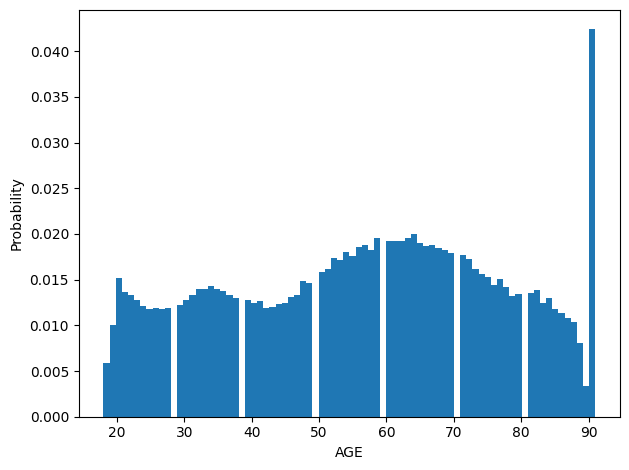

<Figure size 640x480 with 0 Axes>

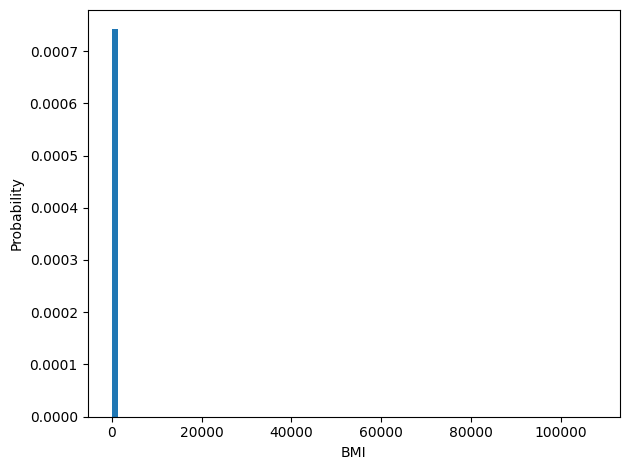

<Figure size 640x480 with 0 Axes>

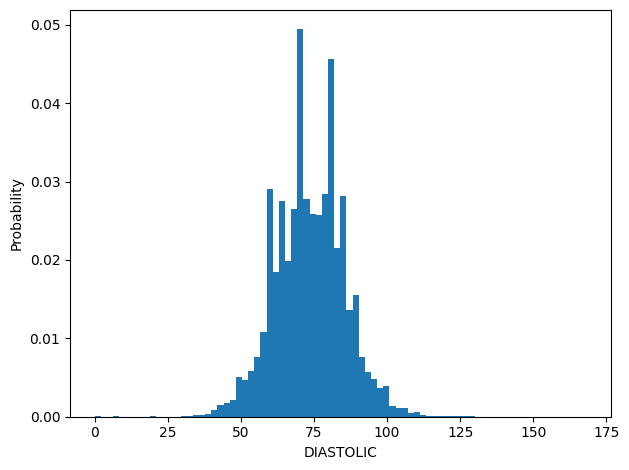

<Figure size 640x480 with 0 Axes>

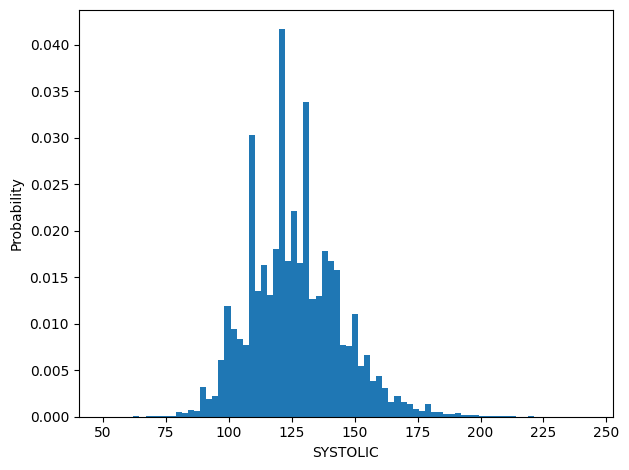

<Figure size 640x480 with 0 Axes>

In [97]:
## Focus on non-binary features, here we check the distribution characteristics of AGE, BMI, DIASTOLIC, and SYSTOLIC columns.
cols = ['AGE', 'BMI', 'DIASTOLIC', 'SYSTOLIC']
for col_name in cols:
    col_data = list(patient_concept_mat_df[col_name])
    print(col_name)
    print('   min value: ', np.nanmin(col_data), ' max value: ', np.nanmax(col_data), ' mean value: ', np.nanmean(col_data), ' median value: ', np.nanmedian(col_data))

# for i in range(len(cols)):
#     plt.hist(list(patient_concept_mat_df[cols[i]]), density=True, bins=80)
#     plt.ylabel('Probability')
#     plt.xlabel(cols[i])
#     plt.show()

import matplotlib.pyplot as plt

for col in cols:
    data = patient_concept_mat_df[col].values  # or .to_numpy()
    plt.figure()
    plt.hist(data, density=True, bins=80)
    plt.ylabel("Probability")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'{col}_hist.png')
    


In [98]:
## Process outliers

# AGE: looks normal except that there are ~7 thousand patients with age 91 because of the age procedure for privacy protection (age >=91 --> 91).

# BMI: the max value is not reasonable --> correspond to an outlier. We remove patients with BMI > 60 or BMI < 10.
print('Num of patients with BMI > 60: %d' % np.sum((patient_concept_mat_df['BMI']) > 60))
print('Num of patients with BMI < 10: %d' % np.sum((patient_concept_mat_df['BMI']) < 10))
patient_concept_mat_df.drop(patient_concept_mat_df[patient_concept_mat_df['BMI'] > 60].index, inplace = True)
patient_concept_mat_df.drop(patient_concept_mat_df[patient_concept_mat_df['BMI'] < 10].index, inplace = True)

# DIASTOLIC: the max value is reasonable but the min value isn't --> correspond to an outlier. We remove patients with Diastolic pressure > 30.
print('Num of patients with DIASTOLIC pressure < 30: %d' % np.sum((patient_concept_mat_df['DIASTOLIC']) < 30))
patient_concept_mat_df.drop(patient_concept_mat_df[patient_concept_mat_df['DIASTOLIC'] < 30].index, inplace = True)

# SYSTOLIC: the min/max value is reasonable given the cohort was admitted to ICU/ED.

patient_concept_mat_df = patient_concept_mat_df.reset_index(drop=True)

# if DIASTOLIC > SYSTOLIC, remove the patient.
dias_bp_list = list(patient_concept_mat_df['DIASTOLIC'])
syst_bp_list = list(patient_concept_mat_df['DIASTOLIC'])
remove_row_index_list = []
for i in range(len(dias_bp_list)):
    dias_bp = dias_bp_list[i]
    syst_bp = syst_bp_list[i]
    if dias_bp != dias_bp and syst_bp != syst_bp and dias_bp >= syst_bp:
        remove_row_index_list.append(i)
if len(remove_row_index_list) > 0:
    patient_concept_mat_df.drop(remove_row_index_list, inplace = True)
    print("%d patients with wrong BP relationship removed." % len(remove_row_index_list))
else:
    print("No BP violations.")
    

Num of patients with BMI > 60: 366
Num of patients with BMI < 10: 120
Num of patients with DIASTOLIC pressure < 30: 62
No BP violations.


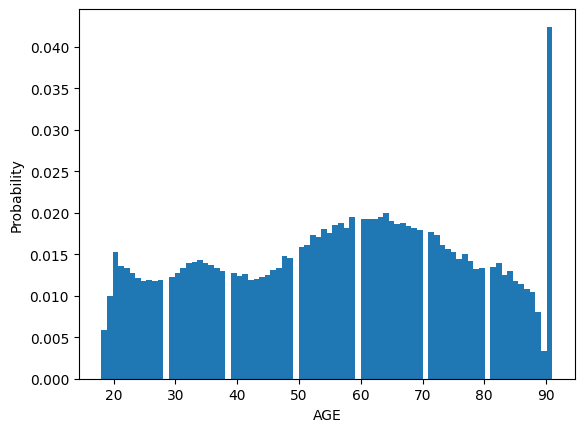

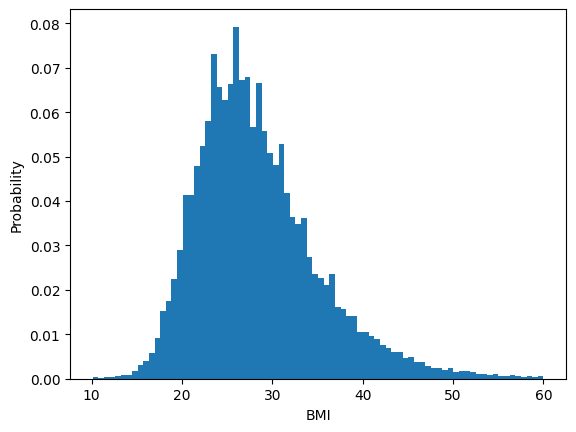

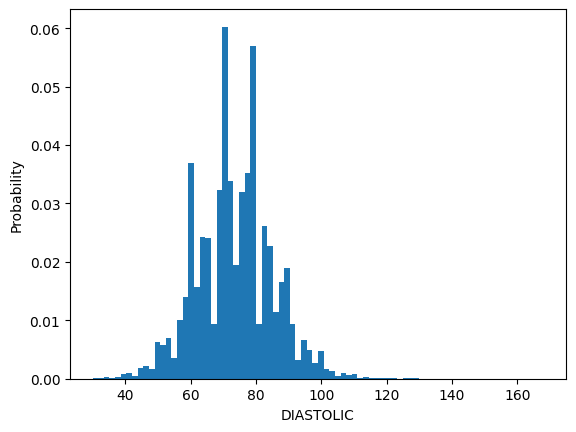

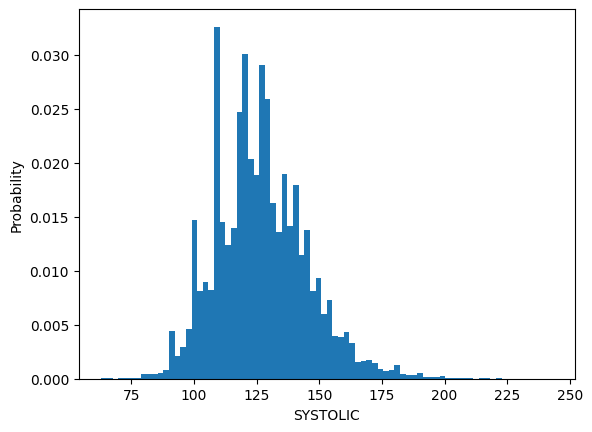

In [99]:
for i in range(len(cols)):
    plt.figure()
    plt.hist(list(patient_concept_mat_df[cols[i]]), density=True, bins=80)
    plt.ylabel('Probability')
    plt.xlabel(cols[i])
    plt.show()
    plt.savefig(f'{cols[i]}_no_out_hist.png')
    plt.close()

## 2. Handle missing values

In [100]:
## Focus on non-binary features, here we check AGE, BMI, DIASTOLIC, and SYSTOLIC columns.
# Check column-wise missing rate
missing_ratio = {}
for col_name in cols:
    missing_ratio[col_name] = patient_concept_mat_df[col_name].isna().sum() / len(patient_concept_mat_df)   
print(missing_ratio)

# Determine missing value imputation strategy. 
# Since the missing rate for the three measures are high, one may choose to remove these columns.
# In this demo, we apply a naive sampling strategy to impute missing data. One can also learn a ML model to predict the measures.
cols = [col_name for col_name in cols if missing_ratio[col_name] > 0]
random.seed(4)
for col_name in cols:
    missing_num = patient_concept_mat_df[col_name].isna().sum()
    col_values = list(patient_concept_mat_df[col_name])
    sampling_list = [x for x in col_values if np.isnan(x) == False]
    for i in range(len(col_values)):
        if np.isnan(col_values[i]) == True:
            col_values[i] = random.choices(sampling_list)[0]

    patient_concept_mat_df[col_name] = col_values


{'AGE': np.float64(0.0), 'BMI': np.float64(0.38620495059365073), 'DIASTOLIC': np.float64(0.43463755767762496), 'SYSTOLIC': np.float64(0.43463755767762496)}


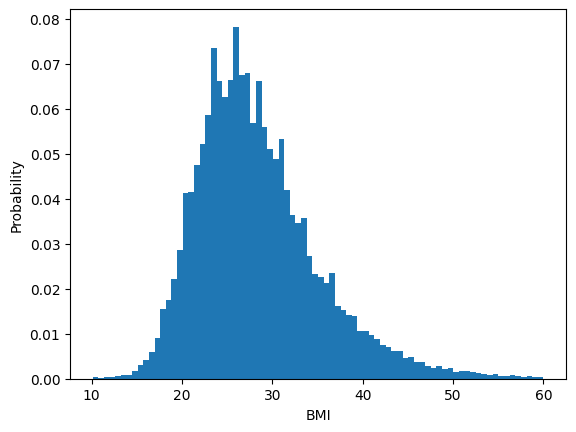

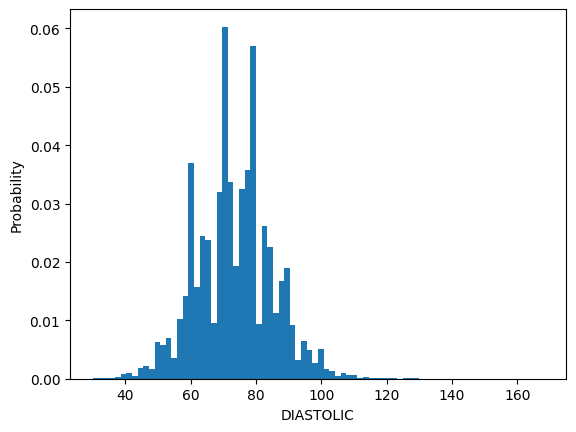

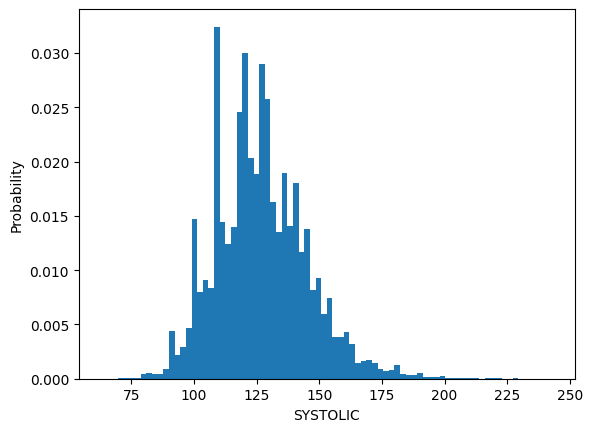

In [101]:
for i in range(len(cols)):
    plt.figure()
    plt.hist(list(patient_concept_mat_df[cols[i]]), density=True, bins=80)
    plt.ylabel('Probability')
    plt.xlabel(cols[i])
    plt.show()
    plt.savefig(f'{cols[i]}_no_miss_hist.png')
    plt.close()

In [27]:
cols

['BMI', 'DIASTOLIC', 'SYSTOLIC']

## 3. Normalize continuous columns

In [102]:
## Normalize the continuous feature in to [0,1]
# Store min max values for each related feature
min_max_log = {}
cols = ['AGE', 'BMI', 'DIASTOLIC', 'SYSTOLIC']
for col_name in cols:
    col_value = np.array(patient_concept_mat_df[col_name])
    min_max_log[col_name] = [np.min(col_value), np.max(col_value)]
    norm_col_value = (col_value - min_max_log[col_name][0]) / (min_max_log[col_name][1] - min_max_log[col_name][0])
    patient_concept_mat_df[col_name] = list(norm_col_value)
print(min_max_log)
np.save(save_folder_name + '/min_max_log.npy', min_max_log)


{'AGE': [np.float64(18.0), np.float64(91.0)], 'BMI': [np.float64(10.1), np.float64(60.0)], 'DIASTOLIC': [np.float64(30.0), np.float64(168.0)], 'SYSTOLIC': [np.float64(63.0), np.float64(243.0)]}


## 4. Remove extremely rare features

In [103]:
## Remove the binary columns with less than x 1s.
cols = list(patient_concept_mat_df.columns)
cols.remove('AGE')
cols.remove('BMI')
cols.remove('DIASTOLIC')
cols.remove('SYSTOLIC')
col_to_remove = []
for col_name in cols:
    col_value = np.array(patient_concept_mat_df[col_name])
    if np.sum(col_value)/len(col_value) < 0.00005:
        col_to_remove.append(col_name)
for col_name in col_to_remove:
    cols.remove(col_name)
    
cols = ['WHITE', 'BLACK', 'ASIAN', 'HISPANIC', 'UN', 'OTHER', 'DIE_1y', 'GENDER'] + cols[8:]

patient_concept_mat_df_ = patient_concept_mat_df[cols + ['AGE','BMI','DIASTOLIC','SYSTOLIC']]
patient_concept_mat_df_.to_csv(save_folder_name + '/preprocessed_training_data.csv', index=False)

In [ ]:
# patient_concept_mat_df_

In [104]:
print(np.sum(patient_concept_mat_df_['WHITE'])) # 121603
print(np.sum(patient_concept_mat_df_['BLACK'])) # 23889
print(np.sum(patient_concept_mat_df_['ASIAN'])) # 7654
print(np.sum(patient_concept_mat_df_['HISPANIC'])) # 10035
print(np.sum(patient_concept_mat_df_['UN'])) # 7561
print(np.sum(patient_concept_mat_df_['OTHER'])) # 10049

121603.0
23889.0
7654.0
10035.0
7516.0
10049.0


In [105]:
all_data = patient_concept_mat_df_.values
np.random.seed(0)
np.random.shuffle(all_data)
training_data = all_data[:int(len(all_data)*0.7)]
testing_data = all_data[int(len(all_data)*0.7):]
training_data_df = pd.DataFrame(data=training_data, columns=list(patient_concept_mat_df_.columns))
testing_data_df = pd.DataFrame(data=testing_data, columns=list(patient_concept_mat_df_.columns))
print(np.sum(training_data_df['DIE_1y'])/len(training_data_df))
print(np.sum(testing_data_df['DIE_1y'])/len(testing_data_df))

training_data_df.to_csv(save_folder_name + '/normalized_training_data.csv', index=False)
testing_data_df.to_csv(save_folder_name + '/normalized_testing_data.csv', index=False)

min_max_log = np.load(save_folder_name + '/min_max_log.npy', allow_pickle=True).item()
for key, min_max in min_max_log.items():
    min_, max_ = min_max[0], min_max[1]
    col_values = np.array(training_data_df[key])
    training_data_df[key] = (1 - col_values)*min_ + col_values*max_
    col_values = np.array(testing_data_df[key])
    testing_data_df[key] = (1 - col_values)*min_ + col_values*max_
    
training_data_df.to_csv(save_folder_name + '/original_training_data.csv', index=False)
testing_data_df.to_csv(save_folder_name + '/original_testing_data.csv', index=False)


0.11257330740898816
0.11380569489524933


In [108]:
!ls /content/gdrive/MyDrive/mimic_synthetic_data/Data/preprocessing/test

column_list_only_diagnosis.npy
mapping_tables
min_max_log.npy
normalized_testing_data.csv
normalized_training_data.csv
one_y_outcome.npy
original_testing_data.csv
original_training_data.csv
patient_bmi_bp_dict.npy
patient_concept_mat_df.csv
patient_concept_mat_only_diagnosis.npy
patient_diagnosis_dict.npy
patient_ICD_diagnosis_final_dict.npy
patient_phecode_diagnosis_final_dict.npy
patient_prescriptions_dict.npy
patient_prescriptions_ingr_rxcui_final_dict.npy
patient_prescriptions_rxcui_final_dict.npy
patient_procedures_hcpcs_dict.npy
patient_procedures_icd_dict.npy
patients_anchor_age_not_last_v_y.npy
patients_dict_w_admission_n_die_inhosp.npy
patients_dict_w_admission.npy
patients_final_dict.npy
patients_w_icd_diag_9_10.npy
patients_w_icd_proc_9_10.npy
preprocessed_training_data.csv
rxnav_cache.json
